In [55]:
from gensim.models import Doc2Vec
from gensim.models import Word2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess

from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical

from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

import numpy as np

import pandas as pd

import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore')

In [35]:
df = pd.read_table('../input/essay-data/training_set_rel3.csv', sep = '\t')

In [36]:
df.head()

essay_id  essay_set      ...       rater3_trait5  rater3_trait6
0         1          1      ...                 NaN            NaN
1         2          1      ...                 NaN            NaN
2         3          1      ...                 NaN            NaN
3         4          1      ...                 NaN            NaN
4         5          1      ...                 NaN            NaN

[5 rows x 28 columns]

*Check for the NaN values*

In [54]:
print("Null Values in Dataset : ", df.isna().sum().sum())
df.info()

Null Values in Dataset :  257931
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12974 entries, 0 to 12973
Data columns (total 28 columns):
essay_id          12974 non-null int64
essay_set         12974 non-null int64
essay             12974 non-null object
rater1_domain1    12974 non-null int64
rater2_domain1    12974 non-null int64
rater3_domain1    127 non-null float64
domain1_score     12974 non-null int64
rater1_domain2    1800 non-null float64
rater2_domain2    1800 non-null float64
domain2_score     1800 non-null float64
rater1_trait1     2290 non-null float64
rater1_trait2     2290 non-null float64
rater1_trait3     2290 non-null float64
rater1_trait4     2290 non-null float64
rater1_trait5     722 non-null float64
rater1_trait6     722 non-null float64
rater2_trait1     2290 non-null float64
rater2_trait2     2290 non-null float64
rater2_trait3     2290 non-null float64
rater2_trait4     2290 non-null float64
rater2_trait5     722 non-null float64
rater2_trait6     722 non-n

In [37]:
nan_count = df.isna().sum()
pd.DataFrame(nan_count).rename(columns = {0: 'NaN_Count'})

NaN_Count
essay_id                0
essay_set               0
essay                   0
rater1_domain1          0
rater2_domain1          0
rater3_domain1      12847
domain1_score           0
rater1_domain2      11174
rater2_domain2      11174
domain2_score       11174
rater1_trait1       10684
rater1_trait2       10684
rater1_trait3       10684
rater1_trait4       10684
rater1_trait5       12252
rater1_trait6       12252
rater2_trait1       10684
rater2_trait2       10684
rater2_trait3       10684
rater2_trait4       10684
rater2_trait5       12252
rater2_trait6       12252
rater3_trait1       12847
rater3_trait2       12847
rater3_trait3       12847
rater3_trait4       12847
rater3_trait5       12847
rater3_trait6       12847

**Remove the attributes having more than 80% NaN values**

In [38]:
drop_headers = []
for i in range(len(nan_count)):
    if nan_count[i]/len(df) > .8:
        drop_headers.append(nan_count.index[i])
df_dropped = df.drop(drop_headers, axis = 1)
df_dropped.head()

essay_id  essay_set      ...       rater2_domain1  domain1_score
0         1          1      ...                    4              8
1         2          1      ...                    4              9
2         3          1      ...                    3              7
3         4          1      ...                    5             10
4         5          1      ...                    4              8

[5 rows x 6 columns]

In [39]:
# Function for removing punctuation
string_punctuation = string.punctuation
def punctuation_removal(sentence):
    return ''.join([i for i in sentence if i not in string_punctuation])

# Function removing stop words from a sentence
stop_words = list(set(stopwords.words("english")))
def stop_word_removal(sentence):
    tokens = word_tokenize(sentence)
    stop_word_free_sentences = [word for word in tokens if word not in stop_words]
    return ' '.join(stop_word_free_sentences)

# Function for stemming the words in a sentence
porter_stemmer = PorterStemmer()
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# Applying the stemming, stop word removal, punctuation removal on the dataset
df_dropped['essay'] = df_dropped['essay'].apply(stem_sentences)
df_dropped['essay'] = df_dropped['essay'].apply(stop_word_removal)
df_dropped['essay'] = df_dropped['essay'].apply(punctuation_removal)

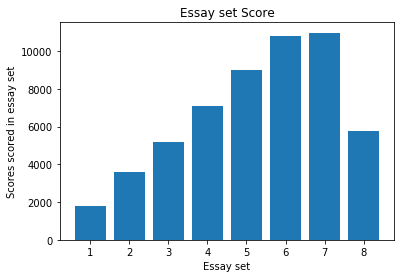

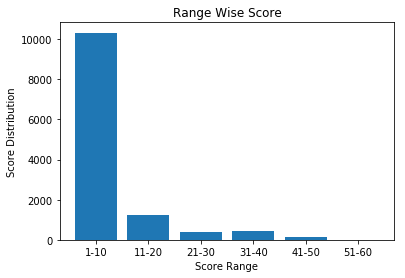

In [28]:
# Function for plotting bar graph
def bar_graph(dictionary, xlabel, ylabel, graph_title):
    plt.bar(range(len(dictionary)), list(dictionary.values()), align='center')
    plt.xticks(range(len(dictionary)), list(dictionary.keys()))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(graph_title)
    plt.show()

# Frequency distribution dictionary, which gives the information about number of essay in the 
# particular score range
frequency_distribution = {"1-10": 0 ,"11-20": 0,"21-30": 0 , "31-40":0, "41-50":0, "51-60":0}

# Set frequency dictionary, this dictionary gives the information aboout the essay set which got
# the maximum score
set_frequency_distribution = {1: 0 ,2: 0,3: 0 , 4:0, 5:0, 6:0, 7:0, 8:0}
essay_set = df_dropped["essay_set"].value_counts()
for key, rows in df_dropped.iterrows():
    set_frequency_distribution[df_dropped.loc[key, "essay_set"]] += df_dropped.loc[key, "essay_set"]

    
bar_graph(set_frequency_distribution, "Essay set", "Scores scored in essay set", 
          "Essay set Score")

# Getting the score range distribution
score = df_dropped["domain1_score"]
for i in score:
    if i >= 1 and i <= 10:
        frequency_distribution["1-10"] += 1
    elif i >= 11 and i <= 20:
        frequency_distribution["11-20"] += 1
    elif i>=21 and i <= 30:
        frequency_distribution["21-30"] += 1
    elif i <= 31 and i <= 40:
        frequency_distribution["31-40"] += 1
    elif i >= 41 and i <= 50:
        frequency_distribution["41-50"] += 1
    elif i >= 51 and i <= 60:
        frequency_distribution["51-60"] += 1
    else:
        continue
        
bar_graph(frequency_distribution, 'Score Range', 'Score Distribution', 'Range Wise Score')

In [41]:
#Helper function to convert a document to a vector using doc2vec
def tag_docs(docs):
    tagged = docs.apply(lambda r: TaggedDocument(words=simple_preprocess(r['essay']), tags=[r.domain1_score]), axis=1)
    return tagged
def train_doc2vec_model(tagged_docs):
    sents = tagged_docs.values
    doc2vec_model = Doc2Vec(sents, vector_size=100, window=1, epochs=20, dm=1, worker = 4)
    return doc2vec_model
def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=200)) for doc in sents])
    return targets, regressors

In [ ]:
#covert the docs to vector using doc2vec
data = {'essay': df_dropped.essay, 'domain1_score': df_dropped.domain1_score}
tagged = tag_docs(pd.DataFrame(data))
model_data = train_doc2vec_model(tagged)
y, X = vec_for_learning(model, tagged)

**Dimensionality reduction using t-SNE to visualize the data in two dimensions**

In [ ]:
dim_2 = TSNE().fit_transform(pd.DataFrame(list(X)))

In [ ]:
sns.set(rc={'figure.figsize':(20, 7.5)})
g = sns.scatterplot([i[0] for i in dim_2], [i[1] for i in dim_2], hue = df.essay_set, palette = sns.color_palette("bright", 8))
g.set_title('TSNE: Essay-Set Visualization')

**tfidf vector conversion of the essays**

In [ ]:
vectorizer = TfidfVectorizer()
X_transformed = vectorizer.fit_transform(df_dropped['essay'])

**Predict essay-set**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, df_dropped['essay_set'], test_size = 0.25)

In [ ]:
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train)

In [ ]:
y_pred = svclassifier.predict(X_test)
accuracy_score(y_test, y_pred)

*Inference from the above result is that essay-set can be predicted which a very high accuracy for an essay*

**Predict Score**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, df_dropped['domain1_score'], test_size = 0.25)

# SVM

In [ ]:
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train)

In [ ]:
y_pred = svclassifier.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Mean Squared Error: ", mean_squared_error(_test, y_pred))

In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(45, 45, 45))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Mean Squared Error: ", mean_squared_error(_test, y_pred))

*Results shows that it is difficult to score an essay when the transformation used is tfidf*

**Word2Vec Approach with ANN from Keras**

In [45]:
def artificial_neural_network(data_frame, dimension_value):
    
    # Getting the the vector corresponding to the essay and storing that in X
    # The input data frame has the columns corresponding to the dimension value i,e
    # If we make a vector for of 50 dimension for a essay data frame will have 50 columns
    # where each cell will have a point from the vector, every row in the data frame, is a 
    # vector for that essay
    column_attribute_name = [i for i in range(dimension_value)]
    X = data_frame[column_attribute_name]
    
    # domain1_score is the target value
    Y = data_frame["domain1_score"]
    
    # Getting the categorical representation of the same
    Y = to_categorical(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30)
    model = Sequential()
    
    # As our target column has multiple value, thus this becomes a multi classfication problem
    # So we decided to use to softmax as our activation function in the hidden and output layer
    # our target value ranges from 0 - 60 implies 61 unique values, so we have 61 neurons in the
    # hidden and the output layer
    # Our neural network has three layes input, hidden , output layer
    model.add(Dense(72, input_dim=dimension_value, activation='relu'))
    model.add(Dense(61, activation='softmax'))
    model.add(Dense(61, activation='softmax'))
    
    # Compile model
    # As this a scoring problem apart from accuracy we are using the Mean square error as a 
    # metric too for the evaluation purpose
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse','accuracy'])
    model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test),
              batch_size=50)
    scores = model.evaluate(X_train, y_train)
    scores = model.evaluate(X_test, y_test)
    return (model.metrics_names[1], scores[1]*100)

# Non linear classification using ANN using word2vec
def word_to_vector(data_frame):   
    
    # Vector size
    dimension_value = 50
    reviews = []
    
    # Adding the columns to the data frame, number of columns to add equals to the dimension 
    # value
    for i in range(dimension_value):
        data_frame[i] = 0
    
    # Getting the word2vec model
    for key, rows in data_frame.iterrows():
        reviews.append(data_frame.loc[key, "essay"].split(" "))
    model = Word2Vec(reviews, min_count=1, size = dimension_value)
    
    # Getting the vector representation of the each review by using the word2vec model by
    # iterating over each word of the review and adding all the word's vector and then dividing 
    # it by the length to normalize it
    word2vector = []
    for review in reviews:
        temp = []
        for word in review:
            temp.append(model[word])
        word2vector.append([sum(i)/len(i) for i in zip(*temp)])

    
    weight_data_frame = pd.DataFrame.from_records(word2vector)
    weight_data_frame["domain1_score"] = data_frame["domain1_score"]
    
    mse = artificial_neural_network(data_frame, dimension_value)
    print(mse[0] + " ", mse[1])
word_to_vector(df_dropped)

Accuracy using SVM:  0.21294631389673774


**Doc2Vec Approch**

In [47]:
#convert essays to vector and split the data for training and testing
data = {'essay': df_dropped.essay, 'domain1_score': df_dropped.domain1_score}
train_data, test_data = train_test_split(pd.DataFrame(data), test_size = 0.3)
train_tagged = tag_docs(train_data)
test_tagged = tag_docs(test_data)
model = train_doc2vec_model(train_tagged)
y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)

In [48]:
#helper function to build the neural network using Keras and return the mean squared error
def artificial_neural_network(X_train, y_train, X_test, y_test, dimension_value):
    len_y_train = len(y_train)
    y = y_train + y_test
    y = to_categorical(y)
    y_train = y[:len_y_train]
    y_test = y[len_y_train:]
    model = Sequential()
    model.add(Dense(72, input_dim=dimension_value, activation='relu'))
    model.add(Dense(61, activation='softmax'))
    model.add(Dense(61, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse','accuracy'])
    model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), batch_size=50)
    scores = model.evaluate(X_train, y_train)
    return (model.metrics_names[1], scores[1])

In [49]:
artificial_neural_network(pd.DataFrame(list(X_train)), y_train, pd.DataFrame(list(X_test)), y_test, 100)

Train on 9081 samples, validate on 3893 samples
Epoch 1/100
9081/9081 [==============================] - 1s 100us/step - loss: 0.0787 - mean_squared_error: 0.0159 - acc: 0.9836 - val_loss: 0.0746 - val_mean_squared_error: 0.0157 - val_acc: 0.9836
Epoch 2/100
9081/9081 [==============================] - 0s 54us/step - loss: 0.0706 - mean_squared_error: 0.0155 - acc: 0.9836 - val_loss: 0.0676 - val_mean_squared_error: 0.0153 - val_acc: 0.9836
Epoch 3/100
9081/9081 [==============================] - 0s 55us/step - loss: 0.0641 - mean_squared_error: 0.0150 - acc: 0.9836 - val_loss: 0.0620 - val_mean_squared_error: 0.0147 - val_acc: 0.9836
Epoch 4/100
9081/9081 [==============================] - 0s 49us/step - loss: 0.0590 - mean_squared_error: 0.0144 - acc: 0.9836 - val_loss: 0.0577 - val_mean_squared_error: 0.0143 - val_acc: 0.9836
Epoch 5/100
9081/9081 [==============================] - 0s 55us/step - loss: 0.0551 - mean_squared_error: 0.0140 - acc: 0.9836 - val_loss: 0.0546 - val_mean_s

Epoch 42/100
9081/9081 [==============================] - 0s 45us/step - loss: 0.0285 - mean_squared_error: 0.0080 - acc: 0.9906 - val_loss: 0.0440 - val_mean_squared_error: 0.0125 - val_acc: 0.9825
Epoch 43/100
9081/9081 [==============================] - 0s 44us/step - loss: 0.0281 - mean_squared_error: 0.0079 - acc: 0.9908 - val_loss: 0.0441 - val_mean_squared_error: 0.0125 - val_acc: 0.9825
Epoch 44/100
9081/9081 [==============================] - 0s 44us/step - loss: 0.0277 - mean_squared_error: 0.0078 - acc: 0.9909 - val_loss: 0.0444 - val_mean_squared_error: 0.0126 - val_acc: 0.9824
Epoch 45/100
9081/9081 [==============================] - 0s 44us/step - loss: 0.0274 - mean_squared_error: 0.0077 - acc: 0.9910 - val_loss: 0.0447 - val_mean_squared_error: 0.0127 - val_acc: 0.9825
Epoch 46/100
9081/9081 [==============================] - 0s 44us/step - loss: 0.0271 - mean_squared_error: 0.0075 - acc: 0.9912 - val_loss: 0.0450 - val_mean_squared_error: 0.0127 - val_acc: 0.9825
Epoch

9081/9081 [==============================] - 0s 43us/step - loss: 0.0180 - mean_squared_error: 0.0046 - acc: 0.9948 - val_loss: 0.0598 - val_mean_squared_error: 0.0148 - val_acc: 0.9817
Epoch 84/100
9081/9081 [==============================] - 0s 45us/step - loss: 0.0178 - mean_squared_error: 0.0046 - acc: 0.9949 - val_loss: 0.0607 - val_mean_squared_error: 0.0149 - val_acc: 0.9817
Epoch 85/100
9081/9081 [==============================] - 0s 44us/step - loss: 0.0178 - mean_squared_error: 0.0045 - acc: 0.9949 - val_loss: 0.0612 - val_mean_squared_error: 0.0149 - val_acc: 0.9817
Epoch 86/100
9081/9081 [==============================] - 0s 46us/step - loss: 0.0176 - mean_squared_error: 0.0045 - acc: 0.9949 - val_loss: 0.0613 - val_mean_squared_error: 0.0150 - val_acc: 0.9818
Epoch 87/100
9081/9081 [==============================] - 0s 44us/step - loss: 0.0175 - mean_squared_error: 0.0044 - acc: 0.9950 - val_loss: 0.0620 - val_mean_squared_error: 0.0150 - val_acc: 0.9817
Epoch 88/100
9081/

('mean_squared_error', 0.39027670900167255)

In [56]:
def SVM(X_train, y_train, X_test, y_test):
    svclassifier = SVC(kernel='linear')  
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    print("Accuracy using SVM: ",accuracy_score(y_test, y_pred))
    print("MSE using SVM: ",mean_squared_error(y_test, y_pred))
    return

In [57]:
SVM(X_train, y_train, X_test, y_test)

Accuracy using SVM:  0.3727202671461598
MSE using SVM:  9.011816080143848


*SVM works best when you have data that is linearly separable. This low accuracy indicates that the data contains nonlinearity. Neural Network are considered to be best in learning the nonlinearty present in the data.*